<a href="https://colab.research.google.com/github/purbid/topic_modeling/blob/main/topic_modeling_bow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer, LancasterStemmer
from nltk.stem.porter import *
import numpy as np

import spacy
np.random.seed(2018)
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
stemmer = LancasterStemmer()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!python3 -m spacy download en
!pip install top2vec
!pip install pyLDAvis==3.2.1

  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311938 sha256=e103131c2cd10fcf0c830bcda8b974d2e1555d1bb354dba6ead4baf57ce402ff
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=8b9059bd473ea38c9965e5c57b32c1aae4f4ed0fa43327abe68fd851b1dd4d55
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52373 sha256=e4fe1d000a41c945665ccef38a53e6226c6e0052673d629ddc7daafb75cd634d
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
Successfully built hdbscan umap-learn pynndescent
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [ ]:

df  = pd.read_csv("/content/drive/MyDrive/articles-data.csv")
temp_l = list(df.columns)
temp_l[0] = "article_num"
df.columns = temp_l



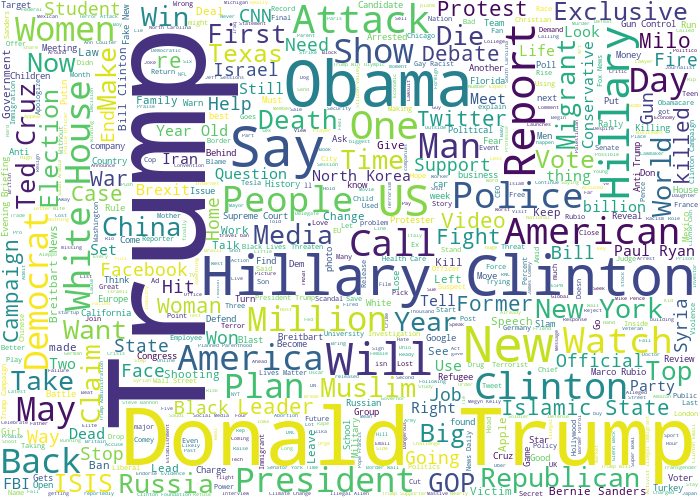

In [ ]:


long_string = ','.join(list(df['title'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, width=700, height=500, contour_width=10, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()


In [ ]:

'''
As we can see the headlines from the articles are from a variety of topics from 
politics to world affairs and contemporary news. The titles also have the name of 
Publishers (New York Times and Breitbart). This can be found in majority of articles 
from these publishers (we check this later), but we must remove these words, since when
we create bag-of-words/embeddings, these words will occur in vastly different articles
(An article for a tech startup and Covid will both have "The New York Times in headline").
This might create problems with differentaiting topics/articles.(Especially with BOW).


We will also truncate the article content. 2 reasons for this:
1. Most of the article content/summary in in the headline and first para.
We can infer the meaning/topic from headline+first para.

2. Smaller text means faster training for models
'''

In [ ]:
'''
Let's see what all publishers are present (possibly). We see how many headings
end with these publisher names.
'''
df["last_chars_title"] = df["title"].str.replace(' ','')
df["last_chars_title"] = df.loc[:,'last_chars_title'].apply(lambda x: x[-9:])
df["last_chars_title"].value_counts().to_frame().head(20)

,last_chars_title
Breitbart,15173
YorkTimes,7806
FastFacts,262
(Opinion),121
naldTrump,89
stigation,52
ryClinton,52
hiteHouse,41
Obamacare,39
uguration,35


In [ ]:
########## as we can see there are publishers Breitbart , New York Times, Fast Facts and (Opinion). Let's remove them.
remove_headline_text = ["The New York Times", "Fast Facts", "- Breitbart", "(Opinion)"]

for i in range(len(df)):
  if i%10000==0:
    print(i)
  for word in remove_headline_text:
    if word in df.iloc[i].title:
      df.at[i, "title"] = df.iloc[i].title.replace(word,'')
  


0
10000
20000
30000
40000


In [ ]:
########### Now we concat the headline and first 50 words of the content
df["headline_content"] = df["title"] + " "+df["content"].apply(lambda x: ' '.join(x.split()[:50]))

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

df_article_list = df.headline_content.values.tolist()
data_words = list(sent_to_words(df_article_list))

print(data_words[:1])


[['house', 'republicans', 'fret', 'about', 'winning', 'their', 'health', 'care', 'suit', 'washington', 'congressional', 'republicans', 'have', 'new', 'fear', 'when', 'it', 'comes', 'to', 'their', 'health', 'care', 'lawsuit', 'against', 'the', 'obama', 'administration', 'they', 'might', 'win', 'the', 'incoming', 'trump', 'administration', 'could', 'choose', 'to', 'no', 'longer', 'defend', 'the', 'executive', 'branch', 'against', 'the', 'suit', 'which', 'challenges', 'the', 'administration', 'authority', 'to', 'spend', 'billions', 'of', 'dollars', 'on']]


In [ ]:
###### create a bigram model from words like Health_Care
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
'''
Removing stopwords, creating bigrams for training and lemmatization.
During lemmatization, we also check the POS tags and keep only
 'NOUN', 'ADJ', 'VERB', 'ADV','PROPN'

'''


data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN'])

print(data_lemmatized[:1])


[['house', 'republicans', 'fret', 'winning', 'health_care', 'suit', 'washington', 'congressional', 'republicans', 'new', 'fear', 'come', 'health_care', 'lawsuit', 'obama', 'administration', 'may', 'win', 'incoming', 'trump', 'administration', 'could', 'choose', 'longer', 'defend', 'executive', 'branch', 'suit', 'challenge', 'administration', 'authority', 'spend', 'billion', 'dollar']]


In [ ]:
data_words_bigrams[0]

['house',
 'republicans',
 'fret',
 'winning',
 'health_care',
 'suit',
 'washington',
 'congressional',
 'republicans',
 'new',
 'fear',
 'comes',
 'health_care',
 'lawsuit',
 'obama',
 'administration',
 'might',
 'win',
 'incoming',
 'trump',
 'administration',
 'could',
 'choose',
 'longer',
 'defend',
 'executive',
 'branch',
 'suit',
 'challenges',
 'administration',
 'authority',
 'spend',
 'billions',
 'dollars']

#### CREATE CORPUS AND DICT FOR BOW

In [ ]:
id2word = corpora.Dictionary(data_lemmatized)

# # Create Corpus
texts = data_lemmatized

##Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# # View how many times each word occurs in first corpus
print(corpus[:1])



[[(0, 3), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1)]]


**TOP WORDS FROM EACH TOPIC AND TRAIN MODEL**


In [ ]:
import time
from pprint import pprint



def make_model(num_topics=12):

  t_start = time.time()

  ##### we try with a random number 12 topics,
  #### later we will find the optimal number of topics

  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num_topics, 
                                            )

  print("time taken for BOW LDA for 15 topics is: "+str(time.time()-t_start)+" seconds")
  '''Let's see what these topics look like, by fetching the top words from each topic:'''
  pprint("******* LIST OF TOP 10 WORDS FROM EACH TOPIC *************")
  pprint(lda_model.print_topics())

  return lda_model

In [ ]:
lda_model = make_model(12)

time taken for BOW LDA for 15 topics is: 28.518962144851685 seconds
'******* LIST OF TOP 10 WORDS FROM EACH TOPIC *************'
[(0,
  '0.010*"get" + 0.009*"year" + 0.008*"people" + 0.008*"may" + 0.008*"thing" + '
  '0.008*"go" + 0.007*"make" + 0.007*"think" + 0.006*"big" + 0.006*"know"'),
 (1,
  '0.013*"startup" + 0.009*"year" + 0.007*"world" + 0.006*"make" + '
  '0.005*"share" + 0.005*"price" + 0.005*"china" + 0.004*"take" + 0.004*"last" '
  '+ 0.003*"may"'),
 (2,
  '0.021*"new" + 0.012*"first" + 0.012*"game" + 0.011*"year" + 0.009*"team" + '
  '0.008*"world" + 0.007*"woman" + 0.007*"day" + 0.007*"york" + 0.005*"win"'),
 (3,
  '0.008*"london" + 0.006*"market" + 0.005*"foundation" + 0.005*"cnn" + '
  '0.005*"year" + 0.005*"uk" + 0.005*"muslim" + 0.005*"football" + 0.004*"say" '
  '+ 0.004*"common"'),
 (4,
  '0.024*"police" + 0.017*"kill" + 0.016*"say" + 0.014*"man" + 0.012*"people" '
  '+ 0.011*"city" + 0.009*"officer" + 0.009*"car" + 0.009*"shoot" + '
  '0.009*"attack"'),
 (5,
  '0.

In [ ]:
lda_model.save("/content/drive/MyDrive/lda_bow")

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.189058  0.151459       1        1  21.430458
4      0.011299 -0.185392       2        1  10.521990
10     0.012385  0.162096       3        1   9.793302
7      0.134698 -0.123462       4        1   9.727205
0     -0.035491  0.085496       5        1   9.177826
5      0.171873 -0.099279       6        1   8.571547
2     -0.124694 -0.010501       7        1   6.532424
9      0.014183  0.080908       8        1   6.521982
11    -0.025197  0.032869       9        1   4.941263
6     -0.162817  0.017905      10        1   4.542687
1     -0.112437 -0.032842      11        1   4.136342
3     -0.072860 -0.079256      12        1   4.102974, topic_info=         Term          Freq         Total Category  logprob  loglift
3211      cnn  18916.000000  18916.000000  Default  30.0000  30.0000
25      trump  30004.000000  30004.000000  Default  29.0000  29.0000
119    donald  14249.000000  14249.000000  Default  28.0000  28.0000
1809  clinton   8862.000000   8862.000000  Default  27.0000  27.0000
50     police   4306.000000   4306.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
19        may    192.859097   4104.506756  Topic12  -5.8563   0.1356
456    attack    186.701149   2813.631516  Topic12  -5.8888   0.4807
55        see    180.732360   2512.422297  Topic12  -5.9213   0.5615
85       take    177.217193   5166.432939  Topic12  -5.9409  -0.1791
526     leave    176.555133   2227.011607  Topic12  -5.9447   0.6587

[948 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
26450      5  0.009685  aaron_hernandez
26450      8  0.987828  aaron_hernandez
6011       3  0.997498              abc
2880       9  0.087599       absolutely
2880      10  0.905189       absolutely
...      ...       ...              ...
400       11  0.004204             york
400       12  0.004204             york
11494     10  0.996298          youtube
6749       8  0.994205              zoo
8771       4  0.988261       zuckerberg

[3320 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 11, 8, 1, 6, 3, 10, 12, 7, 2, 4])

In [ ]:
###### AS we can see above, there is a heavy overlap between topics.
##### Also most of these topics dont seem to make generic sense. Let's try to find an 
###### optimal value of num_topics, that gives the highest value of coherence score(METRIC for topic classification)

In [ ]:
# lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=15, id2word=dictionary, passes=2, workers=2)
# # for idx, topic in lda_model.print_topics(-1):
#     # print('Topic: {} \nWords: {}'.format(idx, topic))

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\\nCoherence Score: ', coherence_lda)

\nCoherence Score:  0.34477139274429


CURRENT COHERENCE SCORE IS 0.34. Let's see if we can 
find a better num_topics, that gives us better coherence score

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print("for num : "+str(num_topics))
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

t_start = time.time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=36, step=5)
print("time for topic search is: "+str(time.time()-t_start)+" seconds")

for num : 2
for num : 7
for num : 12
for num : 17
for num : 22
for num : 27
for num : 32
time for topic search is: 239.98168683052063 seconds


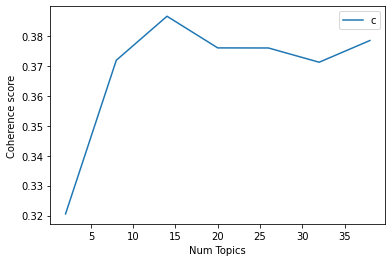

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
########## BASED ON ABOVE GRAPH, the best value of 
########## num topic seems to be around 15 topics.
######### Let's try with that.
lda_model_best = make_model(14)


time taken for BOW LDA for 15 topics is: 29.666422843933105 seconds
'******* LIST OF TOP 10 WORDS FROM EACH TOPIC *************'
[(0,
  '0.024*"police" + 0.020*"kill" + 0.018*"say" + 0.014*"people" + '
  '0.013*"attack" + 0.013*"isis" + 0.012*"car" + 0.012*"city" + '
  '0.009*"officer" + 0.009*"official"'),
 (1,
  '0.021*"russia" + 0.015*"tesla" + 0.014*"russian" + 0.011*"senate" + '
  '0.009*"say" + 0.007*"cnn" + 0.007*"official" + 0.007*"investigation" + '
  '0.007*"report" + 0.006*"hack"'),
 (2,
  '0.010*"say" + 0.009*"london" + 0.008*"hedge_fund" + 0.006*"leave" + '
  '0.006*"oil" + 0.006*"british" + 0.006*"people" + 0.006*"market" + '
  '0.006*"french" + 0.005*"report"'),
 (3,
  '0.016*"news" + 0.011*"syria" + 0.010*"breitbart" + 0.008*"flight" + '
  '0.008*"war" + 0.007*"daily" + 0.007*"terrorist" + 0.006*"syrian" + '
  '0.006*"passenger" + 0.006*"say"'),
 (4,
  '0.055*"cnn" + 0.015*"say" + 0.009*"former" + 0.008*"report" + '
  '0.007*"department" + 0.007*"state" + 0.007*"fox_new

**** VIZUALIZATION OF 14 TOPICS WITH TOP TERMS *******

In [213]:
vis = pyLDAvis.gensim.prepare(lda_model_best, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.158184  0.017901       1        1  22.939795
11    -0.112770  0.139090       2        1   9.309790
0     -0.082983 -0.249412       3        1   8.142531
7     -0.115170 -0.096176       4        1   6.741830
9     -0.046444  0.142516       5        1   6.574482
3      0.029815 -0.123646       6        1   5.880693
12     0.139199  0.083753       7        1   5.789389
1      0.185305 -0.087728       8        1   5.560656
4      0.166783 -0.039049       9        1   5.412405
6      0.020432  0.096432      10        1   5.266418
10    -0.112704  0.016692      11        1   5.117552
2     -0.078431  0.017821      12        1   4.767578
13    -0.006647  0.113333      13        1   4.453349
5     -0.144567 -0.031529      14        1   4.043532, topic_info=         Term          Freq         Total Category  logprob  loglift
25      trump  29716.000000  29716.000000  Default  30.0000  30.0000
3211      cnn  18841.000000  18841.000000  Default  29.0000  29.0000
119    donald  14120.000000  14120.000000  Default  28.0000  28.0000
1809  clinton   8744.000000   8744.000000  Default  27.0000  27.0000
50     police   4373.000000   4373.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
58      south    186.799759    400.079566  Topic14  -5.8737   2.4464
85       take    249.372149   5040.735843  Topic14  -5.5848   0.2017
20        new    243.013204  10325.748993  Topic14  -5.6106  -0.5412
4793      fly    182.994477    452.540436  Topic14  -5.8943   2.3026
1071   report    200.643824   4506.313042  Topic14  -5.8022   0.0963

[1038 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
26450      4  0.990131  aaron_hernandez
6011       5  0.194505              abc
6011       6  0.007628              abc
6011      13  0.797087              abc
969        1  0.200409           accord
...      ...       ...              ...
11494     14  0.993126          youtube
8013       6  0.993180          zealand
10004     11  0.994686             zika
10005     11  0.987808       zika_virus
6749       9  0.993810              zoo

[3871 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 12, 1, 8, 10, 4, 13, 2, 5, 7, 11, 3, 14, 6])

In [211]:
# x=lda_model_best.print_topics()[5][-1].split('''"''')
# x=[x[x1] for x1 in range(len(x)) if x1%2!=0]
# print(x)

From the above Visualization, we can see the top words in all topics.
We can also check the top words overall and how many words (proportion) are present in each topic. Size of bubbles in the viz is proportional to the topic size (number of articles belonging to that topic). We can label the topics as follows(based on the words occuring in them):





1.   **TOPIC 1: US Presidential Elections**

      WORDS:['trump', 'donald', 'president', 'clinton', 'hillary', 'say', 'republican', 'presidential', 'campaign', 'election']



2.   **TOPIC 2: MISC**

      WORDS: ['new', 'year', 'big', 'world', 'first', 'show', 'york', 'get', 'time', 'go']



3.   **TOPIC 3: Crime and Law-Enforcement**  

      WORDS: ['police', 'kill', 'say', 'people', 'attack', 'isis', 'car', 'city', 'officer', 'official']



4.   **TOPIC 4: Crime and Law-Enforcement**

      WORDS: ['man', 'woman', 'charge', 'year', 'new', 'police', 'death', 'die', 'say', 'gun']


5.   **TOPIC 5: Startups and Business**

      WORDS: ['cnn', 'company', 'ceo', 'facebook', 'startup', 'new', 'make', 'share', 'stock', 'tech']


6.   **TOPIC 6: Terrorism and Aviation Crashes**

      WORDS: ['news', 'syria', 'breitbart', 'flight', 'war', 'daily', 'terrorist', 'syrian', 'passenger', 'say']

7.   **TOPIC 7: MISC**

      WORDS: ['cnn', 'us', 'state', 'new', 'say', 'tell', 'governor', 'north_carolina', 'gop', 'washington']


8.   **TOPIC 8: International Information Security**

      WORDS:['russia', 'tesla', 'russian', 'senate', 'say', 'cnn', 'official', 'investigation', 'report', 'hack']



9.   **TOPIC 9: MISC**

      WORDS: ['cnn', 'say', 'former', 'report', 'department', 'state', 'fox_news', 'use', 'wednesday', 'iran']



10.   **TOPIC 10: Education**  

      WORDS: ['student', 'cnn', 'university', 'black', 'college', 'white', 'school', 'team', 'say', 'event']



11.   **TOPIC 11: MISC**

      WORDS: ['amazon', 'photo', 'north_korea', 'say', 'sale', 'customer', 'may', 'day', 'school', 'test']



12.   **TOPIC 12: International Affairs**

      WORDS: ['say', 'london', 'hedge_fund', 'leave', 'oil', 'british', 'people', 'market', 'french', 'report']


13.   **TOPIC 13: HealthCare Laws / HeathCare**

      WORDS: ['house', 'gop', 'bill', 'act', 'win', 'pass', 'obamacare', 'wisconsin', 'get', 'year']

14.   **TOPIC 14: TECHNOLOGY & BUSINESS**

      WORDS: ['apple', 'china', 'google', 'business_insider', 'iphone', 'launch', 'yahoo', 'us', 'uber', 'company']













**USING VECTOR MODEL (TOP2VEC)**




In [ ]:
########## NEXT ONE, WE DO THE SAME TOPIC MODELING, BUT THIS TIME USING A 
########## VECTOR BASED MODEL CALLED TOP2VEC, INSTEAD OF BOW & LDA
from top2vec import Top2Vec


In [ ]:
len(df["headline_content"])


50000

In [ ]:
######### IMPORTANT
'''
The only reason I have taken only titles here, is because training with title+content takes a very long time 
and the notebook times out/RAM exceeds. With sufficient resources we can try the complete texts.
'''

In [ ]:
vector_model = Top2Vec(documents=df["title"].to_list(), speed="learn", workers=8)
vector_model.get_num_topics()


2021-09-07 13:25:58,277 - top2vec - INFO - Pre-processing documents for training
2021-09-07 13:26:00,309 - top2vec - INFO - Creating joint document/word embedding
2021-09-07 13:31:22,928 - top2vec - INFO - Creating lower dimension embedding of documents
2021-09-07 13:32:30,053 - top2vec - INFO - Finding dense areas of documents
2021-09-07 13:32:37,002 - top2vec - INFO - Finding topics


206

In [ ]:
######## model extarcted 206 topics
topic_sizes, topic_nums = vector_model.get_topic_sizes()


In [ ]:
topic_sizes

array([1652,  681,  653,  575,  548,  522,  490,  487,  483,  477,  468,
        460,  457,  435,  429,  428,  425,  425,  422,  421,  419,  415,
        412,  399,  398,  389,  383,  381,  380,  368,  367,  360,  359,
        357,  354,  354,  353,  350,  346,  341,  336,  332,  328,  319,
        315,  315,  314,  314,  312,  310,  309,  305,  305,  300,  300,
        299,  298,  298,  297,  294,  291,  286,  285,  282,  282,  281,
        280,  277,  277,  276,  273,  272,  270,  267,  263,  262,  256,
        247,  245,  243,  239,  239,  239,  238,  237,  234,  233,  233,
        232,  232,  232,  231,  230,  228,  226,  225,  224,  224,  224,
        222,  222,  222,  215,  214,  213,  213,  211,  210,  206,  206,
        205,  205,  204,  203,  200,  197,  195,  193,  192,  192,  188,
        186,  184,  183,  181,  180,  179,  179,  174,  170,  170,  170,
        167,  166,  166,  165,  165,  165,  158,  158,  154,  153,  152,
        152,  151,  150,  150,  147,  146,  144,  1

In [ ]:
'''
We now reduce the original topics to 14. This is done by hierarchical_topic_reduction,
which  merges the topics together, until said number of topics are achieved.
'''
heirar = vector_model.hierarchical_topic_reduction(30)


TOP 10 WORDS IN EACH TOPIC

In [ ]:
topic_words, word_scores, t_nums= vector_model.get_topics()


In [ ]:
print(topic_words[0])

['show' 'fast' 'details' 'wants' 'employee' 'hits' 'strike' 'strikes'
 'families' 'heart' 'meet' 'helps' 'over' 'cancels' 'possible' 'art'
 'blast' 'bans' 'response' 'reporter' 'considering' 'chinese' 'michelle'
 'an' 'search' 'helped' 'cities' 'minutes' 'explosion' 'louisiana'
 'admits' 'promise' 'brings' 'suspended' 'amid' 'era' 'government' 'road'
 'planning' 'sanctions' 'blocks' 'syrian' 'breaking' 'free' 'dc' 'four'
 'weapons' 'rise' 'massive' 'despite']


In [ ]:
############# Topic 1 -> 25, with top 10 words:
for i in heirar:
  word_score_list=[]
  for topic in i:
    for topic_word, word_score in zip(topic_words[topic][:10], word_scores[topic][:10]):
      word_score_list.append((topic_word, word_score))
  sorted(word_score_list, key = lambda x: x[1])
  print(word_score_list[:10])

[('show', 0.6698195), ('fast', 0.66974425), ('details', 0.66336167), ('wants', 0.6627847), ('employee', 0.66150934), ('hits', 0.660667), ('strike', 0.6490939), ('strikes', 0.64729005), ('families', 0.6437243), ('heart', 0.63976514)]
[('left', 0.6725133), ('winner', 0.6660712), ('green', 0.6660153), ('andrew', 0.6607913), ('populist', 0.6467357), ('address', 0.64395165), ('awards', 0.63830936), ('public', 0.62919205), ('documents', 0.6222204), ('against', 0.6199679)]
[('anthony', 0.3509762), ('reid', 0.28904837), ('fidel', 0.2706997), ('valley', 0.2510212), ('classified', 0.21697925), ('weiner', 0.2073325), ('cuba', 0.20008115), ('box', 0.19890632), ('self', 0.1944217), ('huma', 0.19036603)]
[('aid', 0.6295554), ('louisiana', 0.5894176), ('falls', 0.5815727), ('search', 0.5793508), ('show', 0.578527), ('chance', 0.57647663), ('dc', 0.5679785), ('polls', 0.5658774), ('cases', 0.55298823), ('jersey', 0.5505125)]
[('matthew', 0.5840862), ('san', 0.4971147), ('jewish', 0.47740185), ('sachs'

In [ ]:
'''
As we can see above, the vector based method is not very accurate for topic modeling(in our case).
The reason for this can be since we have only taken titles, I might have affected the performance.
Or the model (DOC2VEC based) is not very helpful for these documents, we can try with universal-sentence-encoder.


'''